###**ATOC4500 Data Science Lab - Project**
####Clustering with Meteorological Station Data using LCD data
####last updated: March 11, 2022

**>>>> NOTE: Please run this and other notebooks using a Chrome browser**

LEARNING GOALS:
1. Use k-means clustering as an example of unsupervised (grouping events into different categories) machine learning
2. Become familiar with the limits and applicability of K-means clustering to detect the seasons in Colorado
3. Assess sensitivity of K-means to standardization, changing the input data, and number of clusters.

Here, we will use [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to classify weather data into different clusters.  Each cluster might look like a season.  Why would we cluster weather observations?  We already know which observations are in which season by looking at the date. But it could be quite fun to see how the algorithm decides how to cluster our data and assign each day to a "season". :) <br>

**STEP 1: Import packages and functions we will use**

In [ ]:
import pandas as pd
import numpy as np
import datetime
from google.colab import files

from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

from datetime import datetime

##Introducing your data...##

LCD data downloaded from https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00684/html

Local Climatological Data (LCD) are summaries of climatological conditions from airport and other prominent weather stations managed by NWS, FAA, and DOD. The product includes hourly observations and associated remarks, and a record of hourly precipitation for the entire month. Also included are daily summaries summarizing temperature extremes, degree days, precipitation amounts and winds. The tabulated monthly summaries in the product include maximum, minimum, and average temperature, temperature departure from normal, dew point temperature, average station pressure, ceiling, visibility, weather type, wet bulb temperature, relative humidity, degree days (heating and cooling), daily precipitation, average wind speed, fastest wind speed/direction, sky cover, and occurrences of sunshine, snowfall and snow depth. The source data is global hourly (DSI 3505) which includes a number of quality control checks.

**Here we'll look at the data from Boston, Mass.**

**STEP 2: Read in the Data and Look At It**

In [ ]:
### upload file 72509014739_BOS_2012-2021_hourlydata_munged.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#

Saving 72509014739_BOS_2012-2021_hourlydata_munged.csv to 72509014739_BOS_2012-2021_hourlydata_munged.csv
User uploaded file "72509014739_BOS_2012-2021_hourlydata_munged.csv" with length 11868198 bytes


In [ ]:
### Read in your data
df = pd.read_csv("72509014739_BOS_2012-2021_hourlydata_munged.csv")
### Preview the values in the data frame by printing it
#print(df)
### Print the Shape of the data frame
print(df.shape)

(140239, 10)


In [ ]:
df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph
0,2012-01-01T00:54:00,2012-01-01 00:54:00,40.0,35.0,0.0,83.0,1011.85297,310.0,9.0,23.0
1,2012-01-01T01:00:00,2012-01-01 01:00:00,40.0,35.0,0.0,83.0,1012.19160,310.0,9.0,23.0
2,2012-01-01T01:54:00,2012-01-01 01:54:00,40.0,35.0,0.0,83.0,1012.86890,280.0,9.0,23.0
3,2012-01-01T02:54:00,2012-01-01 02:54:00,41.0,36.0,0.0,82.0,1013.54614,270.0,9.0,23.0
4,2012-01-01T03:54:00,2012-01-01 03:54:00,42.0,36.0,0.0,79.0,1014.22345,290.0,10.0,23.0
...,...,...,...,...,...,...,...,...,...,...
140234,2021-12-31T22:00:00,2021-12-31 22:00:00,44.0,43.0,0.0,96.0,1013.54614,170.0,3.0,20.0
140235,2021-12-31T22:54:00,2021-12-31 22:54:00,45.0,43.0,0.0,93.0,1013.54614,190.0,3.0,20.0
140236,2021-12-31T23:54:00,2021-12-31 23:54:00,46.0,44.0,0.0,93.0,1013.54614,0.0,0.0,20.0
140237,2021-12-31T23:59:00,2021-12-31 23:59:00,46.0,44.0,0.0,93.0,1013.54614,0.0,0.0,20.0


In [ ]:
## add a new variable called "season" to the dataframe df
## this variable contains the season defined traditionally based on the month: 
## DJF=winter, MAM=spring, JJA=summer, SON=fall

## use a dictionary to define seasons from months
### define the seasons as DJF=winter=1, MAM=spring=2, JJA=summer=3, SON=fall=4

seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}
## define a function to assign seasons to months using the dictionary
def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

## apply the function season to one time in my dataset as a sanity check
#print(df['datetime'][0].month)

## apply the function season to all times in my dataset
df['season']=[season(month) for month in pd.DatetimeIndex(df['datetime']).month]

#check
#df['season'][0]

## check the data frame to see if there is a new variable called "season"
df

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph,season
0,2012-01-01T00:54:00,2012-01-01 00:54:00,40.0,35.0,0.0,83.0,1011.85297,310.0,9.0,23.0,1
1,2012-01-01T01:00:00,2012-01-01 01:00:00,40.0,35.0,0.0,83.0,1012.19160,310.0,9.0,23.0,1
2,2012-01-01T01:54:00,2012-01-01 01:54:00,40.0,35.0,0.0,83.0,1012.86890,280.0,9.0,23.0,1
3,2012-01-01T02:54:00,2012-01-01 02:54:00,41.0,36.0,0.0,82.0,1013.54614,270.0,9.0,23.0,1
4,2012-01-01T03:54:00,2012-01-01 03:54:00,42.0,36.0,0.0,79.0,1014.22345,290.0,10.0,23.0,1
...,...,...,...,...,...,...,...,...,...,...,...
140234,2021-12-31T22:00:00,2021-12-31 22:00:00,44.0,43.0,0.0,96.0,1013.54614,170.0,3.0,20.0,1
140235,2021-12-31T22:54:00,2021-12-31 22:54:00,45.0,43.0,0.0,93.0,1013.54614,190.0,3.0,20.0,1
140236,2021-12-31T23:54:00,2021-12-31 23:54:00,46.0,44.0,0.0,93.0,1013.54614,0.0,0.0,20.0,1
140237,2021-12-31T23:59:00,2021-12-31 23:59:00,46.0,44.0,0.0,93.0,1013.54614,0.0,0.0,20.0,1


**STEP 3: Select Data To Use, Convert data into a Numpy Array, Look at data again!**

In [ ]:
#### select the time

##Only select a certain time 
##Note: time is in Local Standard Time.  No daylight savings.
selectdf = df[pd.DatetimeIndex(df['datetime']).hour==12] ## noon
print(len(selectdf))

### tinker later (code that you may want to "borrow" later in this notebook)
#selectdf = df # try selecting all data instead of just noon data

selectdf

4459


,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph,season
16,2012-01-01T12:54:00,2012-01-01 12:54:00,50.0,38.0,0.00,63.0,1013.88480,190.0,8.0,23.0,1
58,2012-01-02T12:54:00,2012-01-02 12:54:00,43.0,17.0,0.00,35.0,1000.67786,280.0,20.0,29.0,1
91,2012-01-03T12:54:00,2012-01-03 12:54:00,29.0,7.0,0.00,39.0,1008.80524,310.0,13.0,17.0,1
124,2012-01-04T12:54:00,2012-01-04 12:54:00,25.0,-2.0,0.00,30.0,1015.57800,270.0,11.0,17.0,1
157,2012-01-05T12:54:00,2012-01-05 12:54:00,38.0,18.0,0.00,44.0,1006.09607,270.0,10.0,21.0,1
...,...,...,...,...,...,...,...,...,...,...,...
140117,2021-12-29T12:54:00,2021-12-29 12:54:00,42.0,27.0,0.00,55.0,1012.19160,30.0,3.0,20.0,1
140161,2021-12-30T12:52:00,2021-12-30 12:52:00,39.0,39.0,0.02,100.0,1012.53020,10.0,5.0,20.0,1
140162,2021-12-30T12:54:00,2021-12-30 12:54:00,40.0,39.0,0.02,97.0,1012.53020,10.0,5.0,20.0,1
140215,2021-12-31T12:18:00,2021-12-31 12:18:00,45.0,42.0,0.00,90.0,1013.20750,80.0,5.0,20.0,1


In [ ]:
## Select variables of interest. Aside variables are called "features" by some in the ML world.

included_cols = ['drytemp_F','prec_inch','RH','pres_mbar','wdir','wspd_mph','wgust_mph'] 

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
data = selectdf.loc[:, selectdf.columns.isin(list(included_cols))].to_numpy()

## check the shape of your data -- should be (N,7) (N, variable)
print(f'Your data are now N observations over 7 variables: {np.shape(data)}')
print(data.shape)

Your data are now N observations over 7 variables: (4459, 7)
(4459, 7)


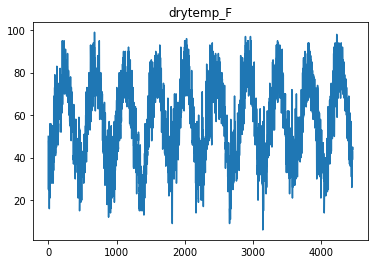

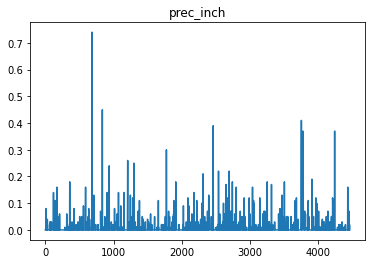

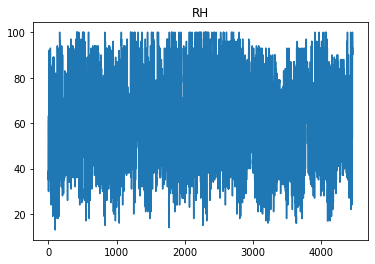

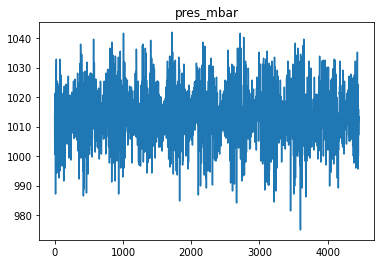

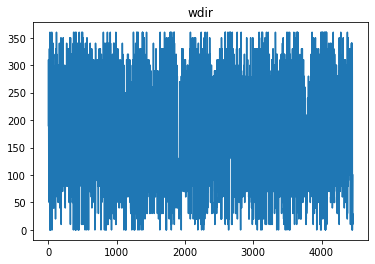

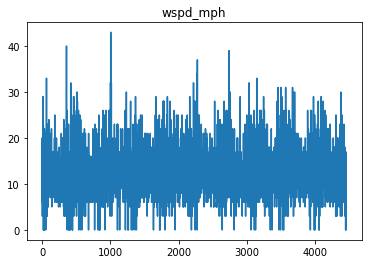

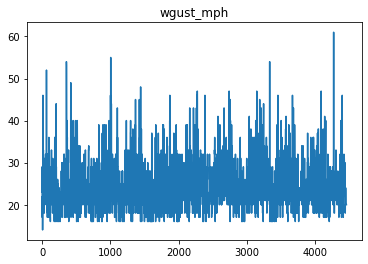

In [ ]:
### option to check out quick plots of your data...
### say yes first time through - double check your input, ALWAYS.
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(data)[1]):
    plt.plot(data[:,i]);
    plt.title(included_cols[i])
    plt.show()

In [ ]:
## for reference: here is an example of using np.nanmean to take the mean of a 
## numpy array and exclude missing values
print(f'take the mean exluding missing data: {np.nanmean(data)}')
print(f'take the mean of all data: {np.mean(data)}')

take the mean exluding missing data: 192.70056334636212
take the mean of all data: 192.70056334636212


**STEP 5: Recale your data to have unit variance**. *Why? Since clustering among features depends on distance, we need to scale all of our features so that all features have equal variance. We don't want the clustering to be dominated by the feature with the largest variance...*

In [ ]:
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.whiten.html
#"Before running k-means, it is beneficial to rescale each feature dimension of the observation 
#set by its standard deviation (i.e. “whiten” it - as in “white noise” where each frequency has equal power). 
#Each feature is divided by its standard deviation across all observations to give it unit variance."
scaled_data = whiten(data) # sci-kit learn's function to standardize data in the clustering toolbox
#scaled_data = data.copy() # uncomment to NOT whiten, but still enable this notebook to run without modifications

## Check that you end up with the same shape as the original data...
print(f'LOOK AT YOUR DATA: shape should be (days, variable), more specifically (366,8): {np.shape(scaled_data)}')

print('mean of each variable')
print(np.mean(scaled_data,axis=0))
print('standard deviation of each variable')
print(np.std(scaled_data,axis=0))

### print the type of scaled_data
print(type(scaled_data))

LOOK AT YOUR DATA: shape should be (days, variable), more specifically (366,8): (4459, 7)
mean of each variable
[  3.10696382   0.23086942   2.81568226 117.07944624   1.77681011
   2.25125232   4.56206469]
standard deviation of each variable
[1. 1. 1. 1. 1. 1. 1.]
<class 'numpy.ndarray'>


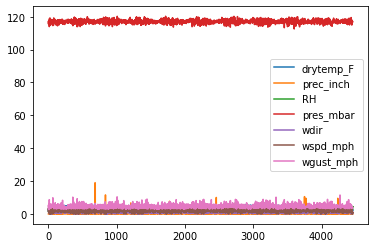

In [ ]:
## check out quick plots of scaled_data... always take this option.
## note: we did not remove the mean...
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(scaled_data)[1]):
    plt.plot(scaled_data[:,i],label=included_cols[i]);
    ## check what happens when you uncomment the two lines below
    #plt.title(included_cols[i])
    #plt.show()
  plt.legend()

**STEP 5: Use K-means clustering to look for patterns in the data**

In [ ]:
## select the number of clusters (i.e., here the number of seasons you want to try to identify using the weather data)
NO_CLUSTERS = 4 # use 4 clusters - see if you get out 4 seasons of winter, fall, spring, summer

## do the clustering, return centroids (i.e., Coordinates of cluster centers.)
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
centroids, _  = kmeans(scaled_data,NO_CLUSTERS,iter=20)

**STEP 6: Visualize your results**.

In [ ]:
## find an index (idx) that is the label for each value in your dataset (i.e, each day at noon)
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html
idx, _ = vq(scaled_data,centroids) # vq returns cluster idx for each observation

## add 1 so that idx is also 1-based like df['season']
idx=idx+1

print('Here is the cluster idx for each day of the year:') 
print(idx.shape) # prints K-mean's season label for each day

Here is the cluster idx for each day of the year:
(4459,)


['drytemp_F', 'prec_inch', 'RH', 'pres_mbar', 'wdir', 'wspd_mph', 'wgust_mph']


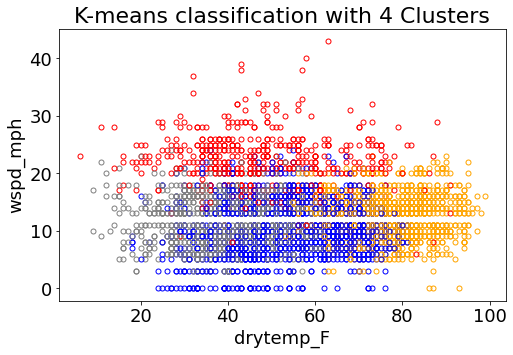

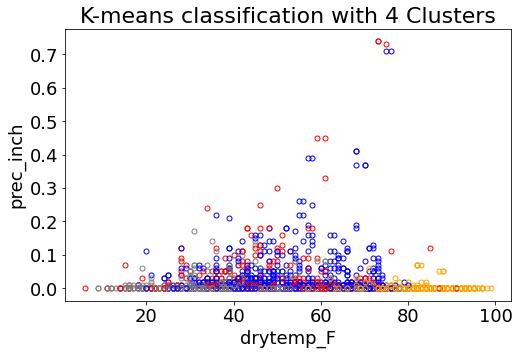

In [ ]:
## Create a few xy scatter plots, where points are colored by "season" (from clustering algorithm).

### Pick any two variables that are a part of included_cols
### ['drytemp_F', 'prec_inch', 'RH', 'pres_mbar', 'wdir', 'wspd_mph', 'wgust_mph'] 
print(included_cols)

##### PLOT #1

### select two variables and put them in vars2plot - # format (x, y)
vars2plot = ['drytemp_F','wspd_mph']
#print(f'plotting these variables: {vars2plot}')

data2plot = [data[:,included_cols.index(var)] for var in vars2plot]

## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  #print(vars2plot[i])
  varidx2plot[i]=included_cols.index(vars2plot[i])
#print(varidx2plot)

### Next plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars2plot[0],fontsize=18);
plt.ylabel(vars2plot[1],fontsize=18);
plt.show()

### You can also plot these variables as scaled values with the cluster centers
#plt.figure(figsize=(8,5))
#plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
##plt.scatter(scaled_data[:, varidx2plot[0]], scaled_data[:, varidx2plot[1]])
#plt.scatter(centroids[:, varidx2plot[0]], centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
#plt.xlabel('scaled '+vars2plot[0],fontsize=18);
#plt.ylabel('scaled '+vars2plot[1],fontsize=18);
#plt.show()

##### PLOT #2

### select two variables and put them in vars2plot - # format (x, y)
vars2plot = ['drytemp_F','prec_inch']
#print(f'plotting these variables: {vars2plot}')

data2plot = [data[:,included_cols.index(var)] for var in vars2plot]

## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  #print(vars2plot[i])
  varidx2plot[i]=included_cols.index(vars2plot[i])
#print(varidx2plot)

### Next plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars2plot[0],fontsize=18);
plt.ylabel(vars2plot[1],fontsize=18);
plt.show()

**STEP 7: Plot histograms of the assigned clusters in the known seasons**. 

In [ ]:
#### prepare data to plot in the histograms

## this is the actual season from the definition in the season dictionary above
season_idx=df['season'][pd.DatetimeIndex(df['datetime']).hour==12].to_numpy()
print(season_idx.shape)

## this is the season from the k-means clustering algorithm
print(idx.shape)

### find what the k-means clustering assigned in each season

## find all of the days in winter, i.e., where season_idx=1
winteridx=np.nonzero(np.where(season_idx==1,1,0))
#print(winteridx) ### uncomment me to check the code
## find what values the k-means classified for this season
winter=idx[winteridx]
#print(winter)  ### uncomment me to check the code

## find all of the days in spring, i.e., where season_idx=2
springidx=np.nonzero(np.where(season_idx==2,1,0))
## find what values the k-means classified for this season
spring=idx[springidx]

## find all of the days in summer, i.e., where season_idx=3
summeridx=np.nonzero(np.where(season_idx==3,1,0))
## find what values the k-means classified for this season
summer=idx[summeridx]

## find all of the days in fall, i.e., where season_idx=4
fallidx=np.nonzero(np.where(season_idx==4,1,0))
## find what values the k-means classified for this season
fall=idx[fallidx]

(4459,)
(4459,)


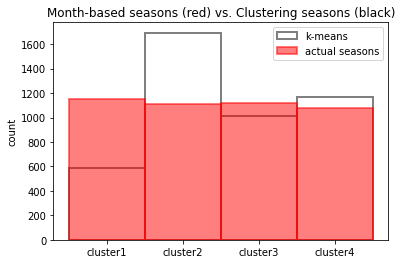

In [ ]:
### Histogram Type #1 - Compare seasons based on month and based on k-means clustering over the entire year

## define bins for the histogram
delta= 1                               ## bin size
minbin= 0.5                             ## minimum bin value
maxbin= 5.5                              ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them

#### all data - plot the histogram
h, mids = np.histogram(idx,bins=hist_bins);
plt.hist(idx,bins=mids,facecolor='white',edgecolor="grey",label='k-means',lw=2);
plt.hist(season_idx,bins=mids,facecolor='r',edgecolor="r",label='actual seasons',alpha=0.5,lw=2);
plt.ylabel('count')
#plt.ylim(0,1000)
plt.xticks(np.arange(1,4+1),labels=['cluster1','cluster2','cluster3','cluster4']);
plt.legend();
plt.title('Month-based seasons (red) vs. Clustering seasons (black)');

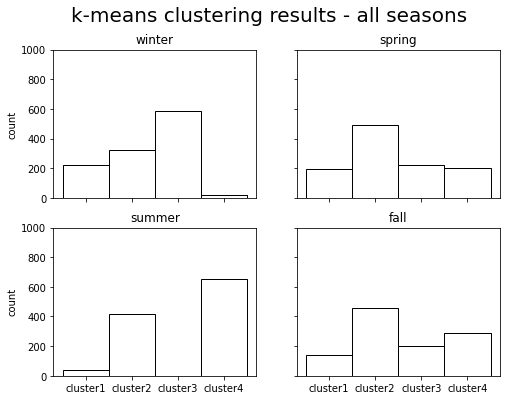

In [ ]:
### Histogram Type #2 - Histograms of seasons based on k-means clustering for each season

## define bins for the histogram
delta= 1                               ## bin size
minbin= 0.5                             ## minimum bin value
maxbin= 5.5                              ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them

## sanity check = plot the histogram of assigned clusters for winter
#h, mids = np.histogram(winter,bins=hist_bins);
#labels4xaxis=['cluster1','cluster2','cluster3','cluster4']
#plt.figure(figsize=(4,4))
#plt.hist(winter,bins=mids,facecolor='w',edgecolor="k");
#plt.xticks(np.arange(1,4+1),labels=labels4xaxis);
#plt.title('Winter');
#plt.show();

### Show all seasons using subplots
### Help with subplots: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

labels4xaxis=['','cluster1','cluster2','cluster3','cluster4']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('k-means clustering results - all seasons',fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(8)

ymax=1000
h, mids = np.histogram(winter,bins=hist_bins);
ax1.hist(winter,bins=mids,facecolor='w',edgecolor="k");
ax1.set_title("winter");
ax1.set_ylabel("count");
ax1.set_ylim(0,ymax)
h, mids = np.histogram(spring,bins=hist_bins);
ax2.hist(spring,bins=mids,facecolor='w',edgecolor="k");
ax2.set_title("spring");
ax2.set_ylim(0,ymax)
h, mids = np.histogram(summer,bins=hist_bins);
ax3.hist(summer,bins=mids,facecolor='w',edgecolor="k");
ax3.set_title("summer");
ax3.set_xticklabels(labels4xaxis);
ax3.set_ylabel("count");
ax3.set_ylim(0,ymax)
h, mids = np.histogram(fall,bins=hist_bins);
ax4.hist(fall,bins=mids,facecolor='w',edgecolor="k");
ax4.set_title("fall");
ax4.set_xticklabels(labels4xaxis);
ax4.set_ylim(0,ymax)

for ax in fig.get_axes():
    ax.label_outer()